In [1]:
import numpy as np
import pandas as pd
import quantstats as qs

from datetime import date
from typing import Callable

## Open database

In [2]:
patterns = {
    'close': 'Fechamento\r\najust p/ prov\r\nEm moeda orig\r\n',
    'negotiable': 'Negociabilidade\n1 meses\nEm moeda orig\n'
}

def clean_dataframe(df, pattern):
    df.columns = df.columns.str.replace(pattern, '')

    dates = pd.to_datetime(df['Data'], dayfirst=True)

    # Detach dates
    tickers = [col for col in df.columns if col != 'Data']
    df = df[tickers]

    # comma_to_dot = lambda x: x.replace('.', '').replace(',', '.')
    # df = df.applymap(comma_to_dot)
    df = df.replace('-', np.nan)
    df = df.apply(pd.to_numeric)

    # Reattach dates
    df['Data'] = dates
    
    # Reorder columns so that dates show up first
    cols = ['Data'] + list(df.columns.drop('Data'))
    df = df[cols]
    
    # Drop weekends and holidays
    df = df.dropna(axis=0, how='all', subset=tickers)
    
    return df

In [3]:
path = './../data/close.csv'
close = pd.read_csv(path, delimiter=',')
close = clean_dataframe(close, patterns['close'])

close.tail(2)

,Data,RRRP3,TTEN3,QVUM3B,QVQP3B,APPA3,APPA4,ABCB3,ABCB4,ABCB11,...,WWOW3,ILMD3,ILMD4,YBRA3B,YDUQ3,ESTC4,ESTC11,OPZI3B,ZAMP3,ZIVI4
9613,2022-11-08,47.00,12.13,NaN,NaN,NaN,NaN,NaN,21.50,NaN,...,NaN,NaN,NaN,NaN,13.98,NaN,NaN,NaN,7.1,NaN
9614,2022-11-09,46.21,12.00,NaN,NaN,NaN,NaN,NaN,21.09,NaN,...,NaN,NaN,NaN,NaN,13.72,NaN,NaN,NaN,7.3,NaN


In [4]:
path = './../data/in.csv'
negotiable = pd.read_csv(path, delimiter=',')
negotiable = clean_dataframe(negotiable, patterns['negotiable'])

negotiable.tail(2)

,Data,RRRP3,TTEN3,QVUM3B,QVQP3B,APPA3,APPA4,ABCB3,ABCB4,ABCB11,...,WWOW3,ILMD3,ILMD4,YBRA3B,YDUQ3,ESTC4,ESTC11,OPZI3B,ZAMP3,ZIVI4
9613,2022-11-08,0.61,0.1,NaN,NaN,NaN,NaN,NaN,0.11,NaN,...,NaN,NaN,NaN,NaN,0.47,NaN,NaN,NaN,0.06,NaN
9614,2022-11-09,0.61,0.1,NaN,NaN,NaN,NaN,NaN,0.10,NaN,...,NaN,NaN,NaN,NaN,0.46,NaN,NaN,NaN,0.06,NaN


In [5]:
def get_IBRX_assets(today_date):
    s = negotiable.set_index('Data').loc[:today_date].iloc[-1]
    s = s.sort_values(ascending=False)
    return s.index[:100]

## Defining utility functions

In [6]:
def how_many_days_since_last_trading_day(today_date, df):
    """
    :param date today_date:
    :param pd.DataFrame df: DataFrame with a datetime index
    """
    quotes_until_now = df.loc[:today_date, :].reset_index(names='index')
    
    last_day = quotes_until_now.iloc[-1]['index']
    if last_day.date() == today_date:
        last_day = quotes_until_now.iloc[-2]['index']
    
    return today_date - last_day.date()


def trading_day_immediately_before(today_date, df):        
    return today_date - how_many_days_since_last_trading_day(today_date, df)

def run_backtest(
    close: pd.DataFrame, 
    start_date: date, 
    end_date: date, 
    rebalance: int,
    get_tickers: Callable
    ):
    """
    :param pd.DataFrame close: DataFrame of closing prices with a datetime index
    :param date start_date:
    :param date end_date:
    :param date rebalance: rebalancing time delta in months
    """
    portfolio = pd.DataFrame()
    
    today = pd.Timestamp(start_date)
    while today.date() <= end_date:
        next_date = today + pd.DateOffset(months=rebalance)
        
        # Asset selection
        tickers = get_tickers(close, today)
        
        # Once we have our tickers, we assemble our quotes
        first_quote = trading_day_immediately_before(today.date(), close)
        last_quote  = trading_day_immediately_before(next_date.date(), close)
        
        iteration_returns = close.loc[first_quote:last_quote, tickers].pct_change().mean(axis=1)
        iteration_returns = iteration_returns.to_frame(name='pctChange')
        iteration_returns = iteration_returns.iloc[1:].loc[:end_date]
        
        portfolio = pd.concat([portfolio, iteration_returns])
        
        today = next_date
        
    return portfolio

## Testing a momentum strategy

In [7]:
def get_tickers(df, today_date):
    lookback = 12
    start_of_analysis = today_date - pd.DateOffset(months=lookback)
    
    ibrx_filter = df.loc[start_of_analysis:today_date, get_IBRX_assets(today_date.date())]
    returns = ibrx_filter.pct_change().add(1).cumprod().iloc[-1]
    
    return returns.sort_values(ascending=False).index[:10]

In [8]:
p = run_backtest(close.set_index('Data'), date(2015, 1, 1), date(2020, 1, 1), 1, get_tickers)

                           Strategy
-------------------------  ----------
Start Period               2015-01-02
End Period                 2019-12-30
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          312.33%
CAGR﹪                     32.8%

Sharpe                     1.34
Prob. Sharpe Ratio         99.8%
Smart Sharpe               1.28
Sortino                    1.93
Smart Sortino              1.84
Sortino/√2                 1.37
Smart Sortino/√2           1.3
Omega                      1.25

Max Drawdown               -28.31%
Longest DD Days            363
Volatility (ann.)          23.68%
Calmar                     1.16
Skew                       -0.7
Kurtosis                   5.8

Expected Daily %           0.11%
Expected Monthly %         2.39%
Expected Yearly %          32.75%
Kelly Criterion            11.0%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.33%
Expected Shortfall (cVaR)  -2.33%

Max Consecutive Wins       1

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2017-02-21,2017-05-18,2017-08-31,191,-28.309783,-26.173084
2,2015-07-17,2016-01-26,2016-07-14,363,-18.838509,-17.555414
3,2016-11-01,2016-12-22,2017-01-16,76,-13.946357,-13.598766
4,2018-09-10,2018-12-17,2019-01-24,136,-12.708674,-12.597272
5,2017-10-23,2017-11-10,2017-12-21,59,-12.451297,-12.439187


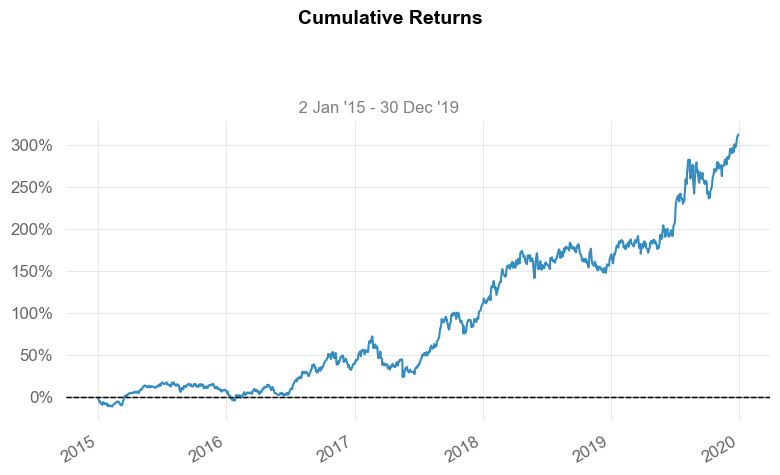

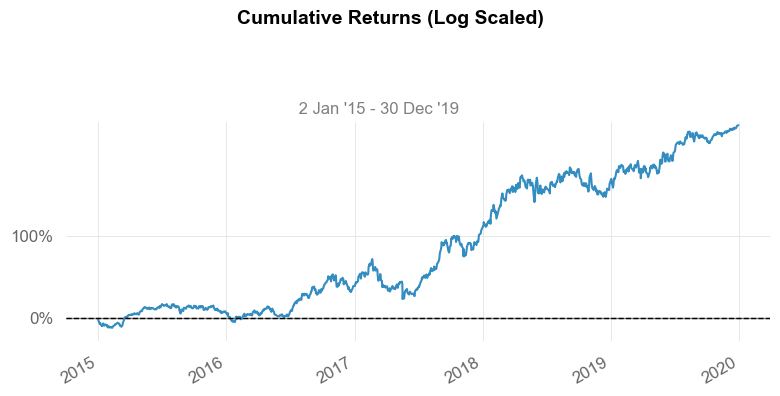

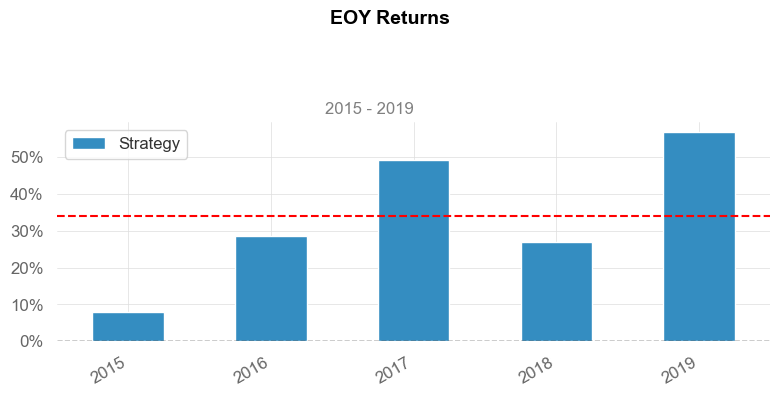

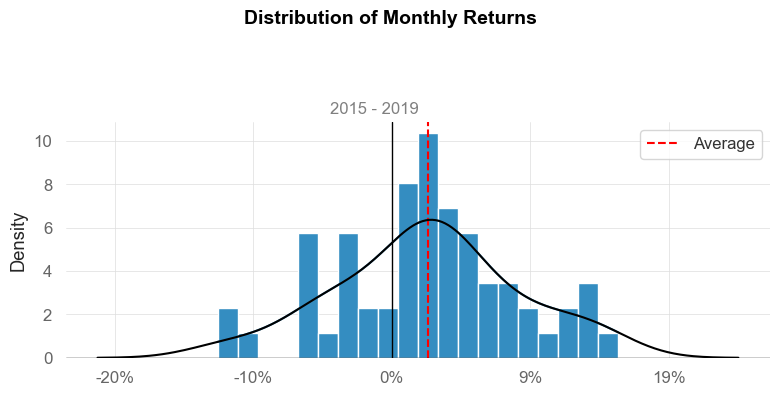

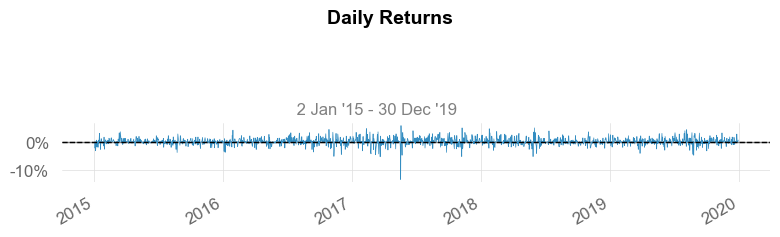

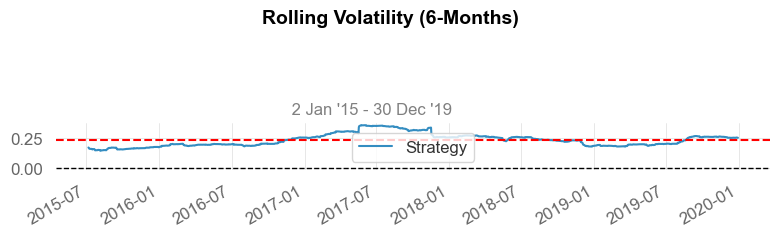

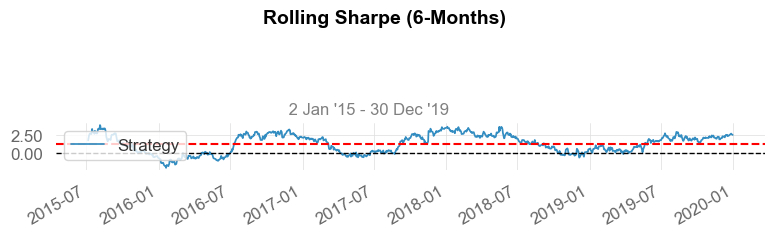

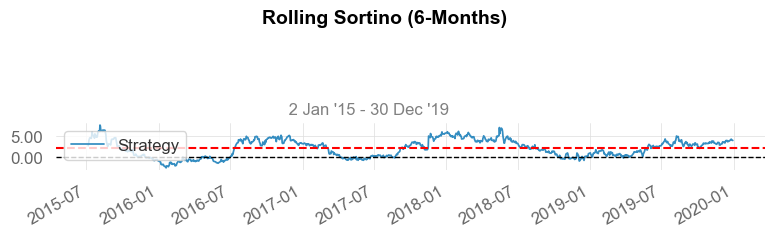

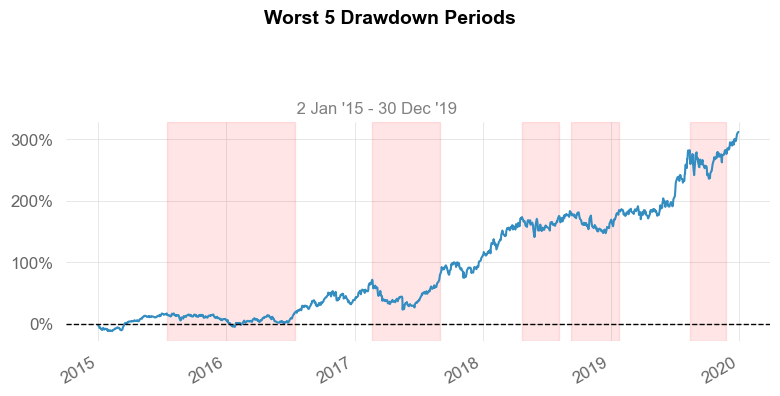

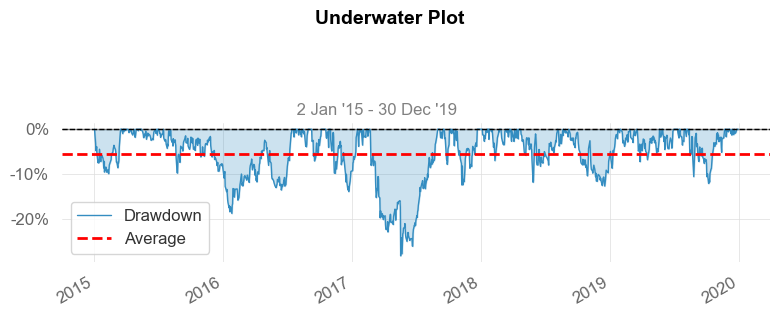

/Users/pedro/Developer/quant-modeling/venv/lib/python3.10/site-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


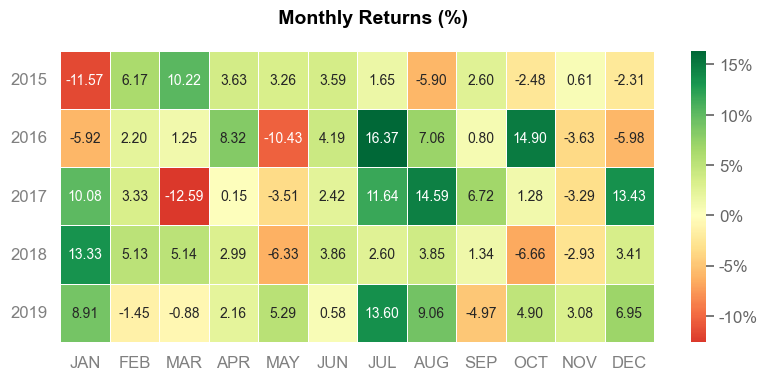

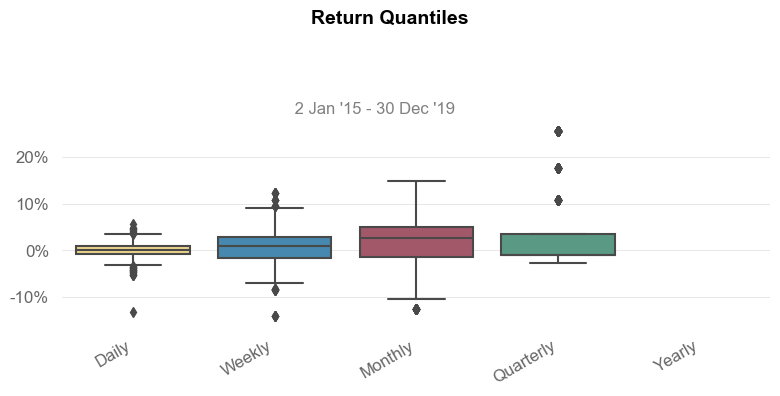

In [9]:
qs.reports.full(p['pctChange'])